In [257]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import zoom
from scipy.ndimage.filters import median_filter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

from tqdm import tqdm

# Resources
- [CAM](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf): Learning Deep Features for Discriminative Localization

In [259]:
"""
Global Variables
"""

# Dataset path
data_path = os.path.join(os.path.sep, 'media', 'gabriel', 
                         'External_2.0_TB', 'ImageNet', 
                         '1000_classes')
classes = next(os.walk(data_path, topdown=True))[1]
classes.sort()
classes = np.array(classes)
print(f'Number of classes found: {len(classes)}')
print("-" * 50)

# Define image processing metadata
image_size = 224
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]


# Instantiate torch loader and dataset
imagenet_dataset = datasets.ImageFolder(
        data_path, 
        transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)            
        ]))
dataloader = DataLoader(
        imagenet_dataset, batch_size=6,
        shuffle=True, num_workers=4)

dataloader_iter = iter(dataloader)

# Download VGG16 model from the pytorch model_zoo
vgg16 = models.vgg16(pretrained=True)
print(f'VGG16 architecture:\n{vgg16}')
print('-' * 50)

# Extract convolution blocks from the network
# Block 1
conv_1_1 = vgg16.features[0:2]
conv_1_2 = vgg16.features[:5]
# Block 2
conv_2_1 = vgg16.features[:7]
conv_2_2 = vgg16.features[:10]
# Block 3
conv_3_1 = vgg16.features[:12]
conv_3_2 = vgg16.features[:14]
conv_3_3 = vgg16.features[:17]
# Block 4
conv_4_1 = vgg16.features[:19]
conv_4_2 = vgg16.features[:21]
conv_4_3 = vgg16.features[:24]
# Block 5
conv_5_1 = vgg16.features[:26]
conv_5_2 = vgg16.features[:28]
conv_5_3 = vgg16.features[:31]
print(f'Example of a convolution block:\n{conv_2_1}')
print('-' * 50)

Number of classes found: 977
--------------------------------------------------
VGG16 architecture:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [260]:
def CAM(img, model, cuda=False):
    
    if cuda:
        img = img.cuda()
        model = model.cuda()
    
    # feature maps
    fm =  model(img)
    maps = fm.sum(dim=[-1, -2], keepdim=True)
    cam = (maps * fm).sum(1)
    return cam

In [261]:
def deprocess_image(x):
    """
    Utility function to convert a float array into a valid uint8 image.
    
    Arguments
        x: A numpy-array representing the generated image.
    
    Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.25
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose(1, 2, 0)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Class = coconut, Label = 255
dim: (224, 224, 3)


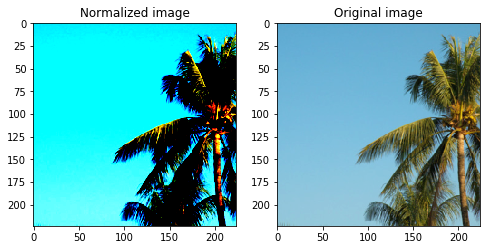

In [270]:
""" 
Sanity check: 
    Display loaded image.

Note: It will look "odd" due to normalization.
"""
# Load small batch of images for testing
images, labels = next(dataloader_iter)
image = images[0].numpy().transpose(1,2,0)
label = labels[0].item()
print(f'Class = {classes[label]}, Label = {label}')
print(f'dim: {image.shape}')

# visualize first image
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1,2,1)
plt.imshow(np.clip(image, 0, 1))
plt.title('Normalized image')

"""
We can get the original image back by reverting
the normalization performed during preprocessing
"""
fig.add_subplot(1,2,2)
_image = get_unnormalized_image(image, std, mean)
plt.imshow(_image)
plt.title('Original image')
plt.show()

In [271]:
cam = CAM(images[0:].detach(), conv_5_3, 
          torch.cuda.is_available())

cam = cam.detach().cpu().numpy()
pred = vgg16.cuda()(images.cuda())
topk = torch.topk(pred, 1)
pred_labels = topk.indices.detach().cpu().numpy().T

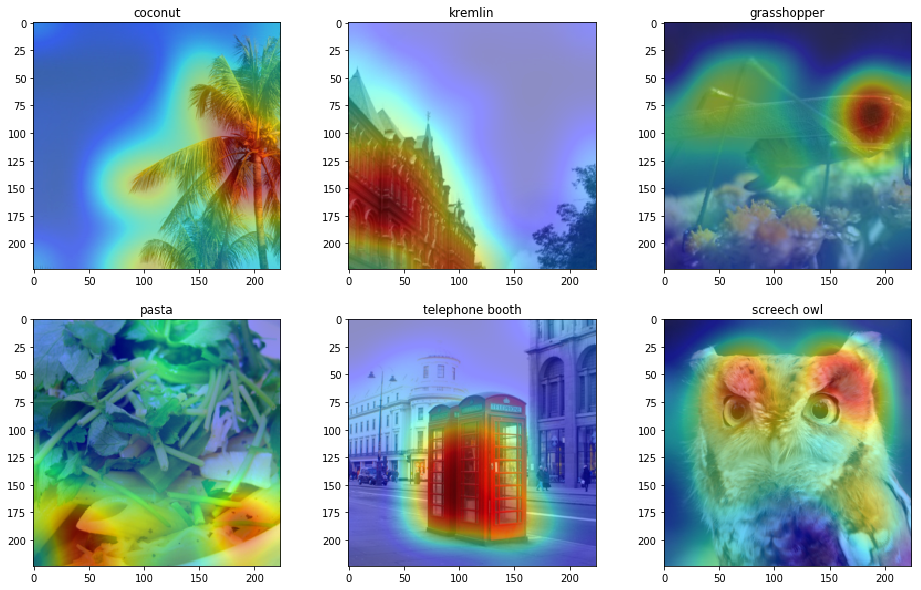

In [272]:
# visualize first image
fig, axs = plt.subplots(2,3, figsize=(16,10), squeeze=False)

axs = axs.flatten()

"""
We can get the original image back by reverting
the normalization performed during preprocessing
"""
for i, hm in enumerate(cam):
    _image = images[i].detach().numpy()
    _image = _image.transpose(1,2,0)
    _image = get_unnormalized_image(_image, std, mean)
    heatmap = zoom(hm, 32).astype(np.uint32)
    _max = heatmap.max()
    _min = heatmap.min()
    heatmap = np.abs((heatmap-_min)/(_max-_min))
    mask = (heatmap * 255).astype(np.uint8)
    _image = np.abs(_image)
    label = classes[labels[i]]
    axs[i].imshow(_image)
    axs[i].imshow(heatmap, cmap='jet', alpha=0.45)
    _ = axs[i].set_title(label)

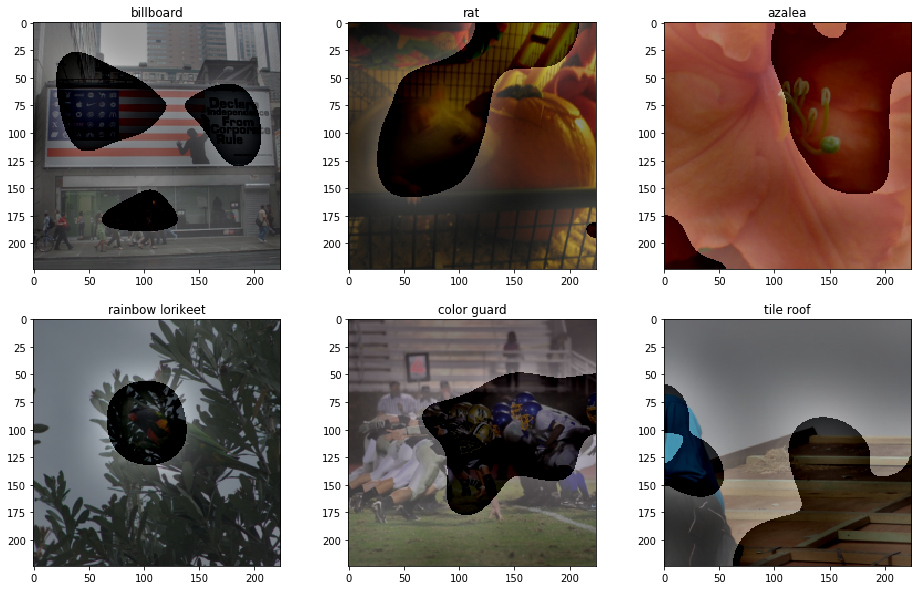

In [265]:
# visualize first image
fig, axs = plt.subplots(2,3, figsize=(16,10), squeeze=False)

axs = axs.flatten()

"""
We can get the original image back by reverting
the normalization performed during preprocessing
"""
for i, hm in enumerate(cam):
    _image = images[i].detach().numpy()
    _image = _image.transpose(1,2,0)
    _image = get_unnormalized_image(_image, std, mean)
    heatmap = zoom(hm, 32).astype(np.uint32)
    _max = heatmap.max()
    _min = heatmap.min()
    heatmap = (heatmap-_min)/(_max-_min)
    mask = (heatmap * 255).astype(np.int8)
    _image = (_image + np.expand_dims(mask, -1))//2
    _image = _image.clip(0, 255)
    label = classes[labels[i]]
    axs[i].imshow(_image)
    _ = axs[i].set_title(label)